In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time    
%matplotlib inline
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from skimage import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/yes" "/content/"
!cp "/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/no" "/content/"

cp: -r not specified; omitting directory '/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/yes'
cp: -r not specified; omitting directory '/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/no'


In [4]:
file_path = "/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed" 

In [5]:
def data_summary(main_path):
    
    yes_path =  "/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/yes" 
    no_path =  "/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/no" 
        
    # number of images in the positive Covid-19 folder
    m_pos = len(listdir(yes_path))
    # number of images in the negative Covid-19 folder
    m_neg = len(listdir(no_path))
    # number of all images
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of images: {m}")
    print(f"Percentage of positive Covid-19 images: {pos_prec}%, number of positive Covid-19 images: {m_pos}") 
    print(f"Percentage of negative Covid-19 images: {neg_prec}%, number of negative Covid-19 images: {m_neg}") 

In [6]:
# Number of dataset and the percentage of positive and negative Covid-19 images
data_summary(file_path)

Number of images: 746
Percentage of positive Covid-19 images: 46.7828418230563%, number of positive Covid-19 images: 349
Percentage of negative Covid-19 images: 53.2171581769437%, number of negative Covid-19 images: 397


In [7]:
  def crop_lung_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_filter = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray_filter, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

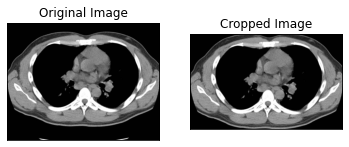

In [8]:
#upload a picture from my Gdrive
!cp "/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/no/1029.png" "/content"

#try data preprocessing into a image
img = cv2.imread('1029.png')
new_img = crop_lung_contour(img, True)

In [9]:
new_img.shape

(318, 511, 3)

In [10]:
from operator import ior
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the lung and ignore the unnecessary rest part of the image
            image = crop_lung_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [11]:
#load data preprocessing
yes_path =  "/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/yes" 
no_path =  "/content/drive/MyDrive/CNN_COVID19/COVID-CT-master/COVID-CT-master/Images-processed/no"

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([yes_path, no_path], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 746
X shape is: (746, 240, 240, 3)
y shape is: (746, 1)


In [12]:
def plot_sample_images(X, y, n=50):
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Covid-19: {label_to_str(label)}")
        plt.show()

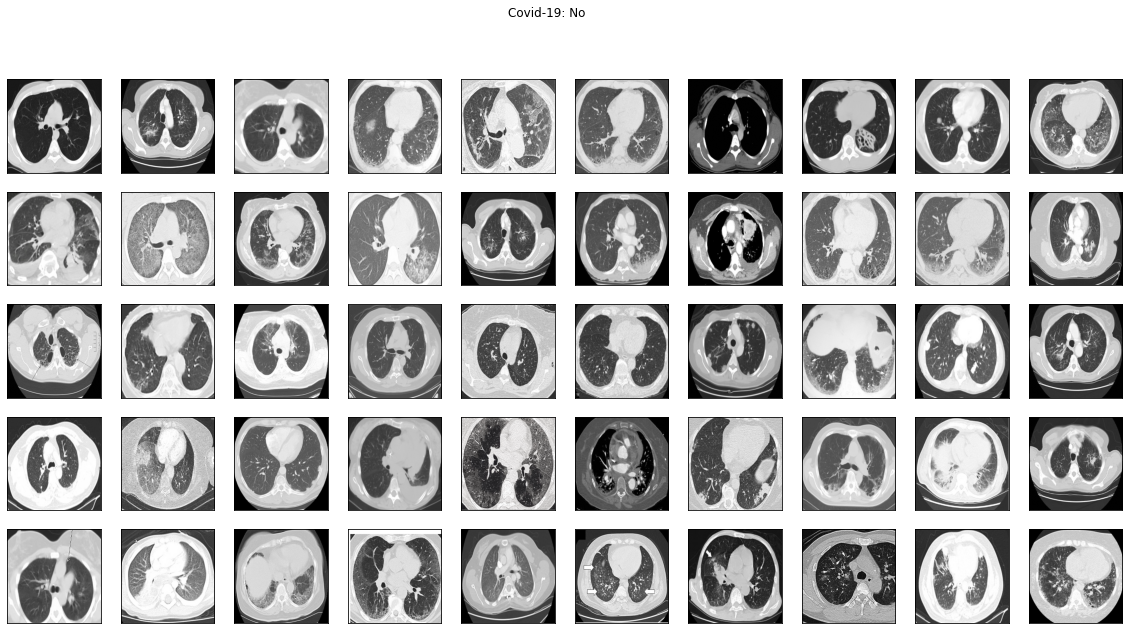

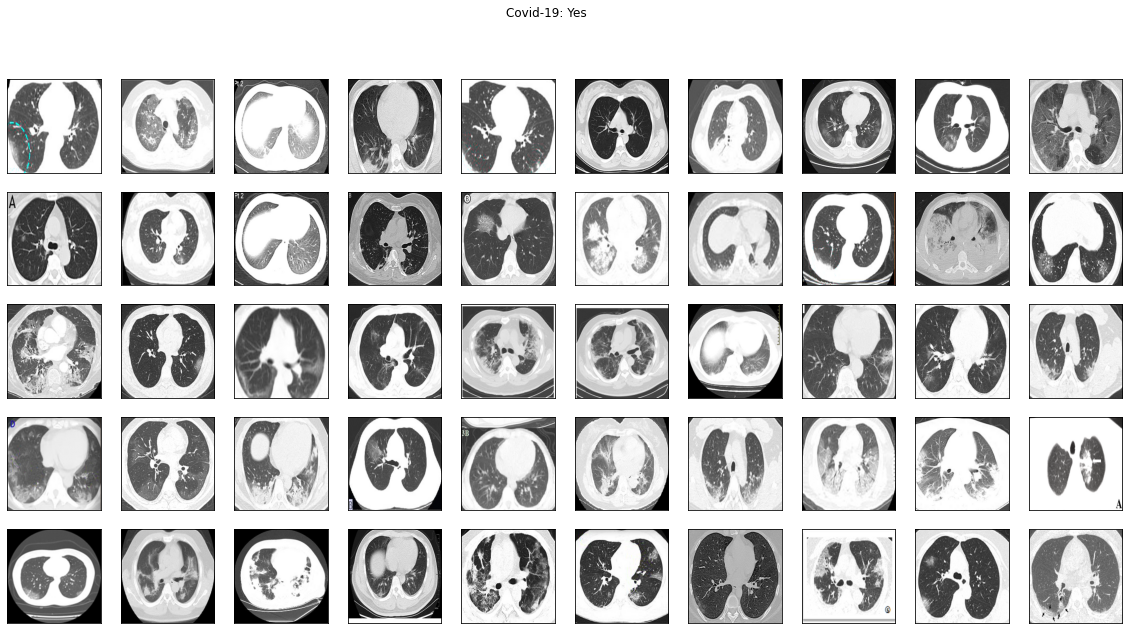

In [13]:
# 50 images of positive and negative Covid-19 images
plot_sample_images(X, y)

In [14]:
def split_data(X, y, test_size=0.2):
       
   # Splits data into training, development and test sets.
  
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [16]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 522
number of development examples = 112
number of test examples = 112
X_train shape: (522, 240, 240, 3)
Y_train shape: (522, 1)
X_val (dev) shape: (112, 240, 240, 3)
Y_val (dev) shape: (112, 1)
X_test shape: (112, 240, 240, 3)
Y_test shape: (112, 1)


In [17]:
def build_model(input_shape):

    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Covid-19DetectionModel')
    
    return model

In [18]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "Covid-19DetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                            

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
#train the model data with epochs 25
model.fit(x=X_train, y=y_train, batch_size=32, epochs=35, validation_data=(X_val, y_val))

Epoch 1/35
17/17 [==============================] - 55s 3s/step - loss: 1.1087 - accuracy: 0.5287 - val_loss: 1.4980 - val_accuracy: 0.4286
Epoch 2/35
17/17 [==============================] - 53s 3s/step - loss: 0.6927 - accuracy: 0.6513 - val_loss: 0.7329 - val_accuracy: 0.4732
Epoch 3/35
17/17 [==============================] - 52s 3s/step - loss: 0.6828 - accuracy: 0.6111 - val_loss: 1.3378 - val_accuracy: 0.4464
Epoch 4/35
17/17 [==============================] - 51s 3s/step - loss: 0.5703 - accuracy: 0.6935 - val_loss: 0.8444 - val_accuracy: 0.4821
Epoch 5/35
17/17 [==============================] - 51s 3s/step - loss: 0.5256 - accuracy: 0.7241 - val_loss: 0.8775 - val_accuracy: 0.4911
Epoch 6/35
17/17 [==============================] - 51s 3s/step - loss: 0.5000 - accuracy: 0.7375 - val_loss: 0.6539 - val_accuracy: 0.5982
Epoch 7/35
17/17 [==============================] - 52s 3s/step - loss: 0.4775 - accuracy: 0.7759 - val_loss: 0.6401 - val_accuracy: 0.6071
Epoch 8/35
17/17 [==

In [28]:
#save model
model.save("/content/drive/MyDrive/CNN_COVID19/model_covid19.h5")

*plot* loss and accuracy

In [29]:

history = model.history.history

In [30]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [31]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

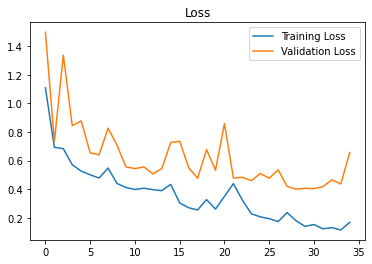

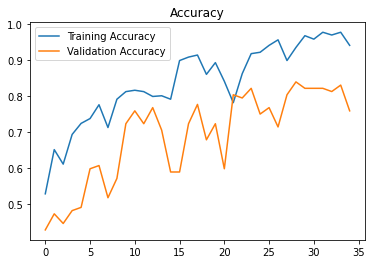

In [32]:
plot_metrics(history) 

In [33]:
eval_score = model.evaluate(X_test, y_test)
print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

4/4 [==============================] - 3s 637ms/step - loss: 0.8500 - accuracy: 0.6607
Test loss: 0.849964439868927
Test accuracy: 0.6607142686843872
